# <center>PROJECT - Energy Consumption</center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

In [2]:
MAX_FORECAST_HORIZON = 14

## EXPLORATORY DATA ANALYSIS

In [3]:
dataset = pd.read_csv('data/EnergyConsumption.csv', parse_dates=['Time'], index_col=0)
dataset.rename(columns={'Energy Consumption':'Energy'}, inplace=True)

plt.rc("figure",figsize=(20, 5))

In [4]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 866566 entries, 0 to 866565
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   Time    866566 non-null  datetime64[ns]
 1   Energy  866566 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 19.8 MB


***
No Null values found.
***

In [5]:
dataset.head()

,Time,Energy
0,2022-01-29 15:49:00,0.03
1,2022-01-29 15:49:30,0.03
2,2022-01-29 15:50:00,0.03
3,2022-01-29 15:50:30,0.03
4,2022-01-29 15:51:00,0.03


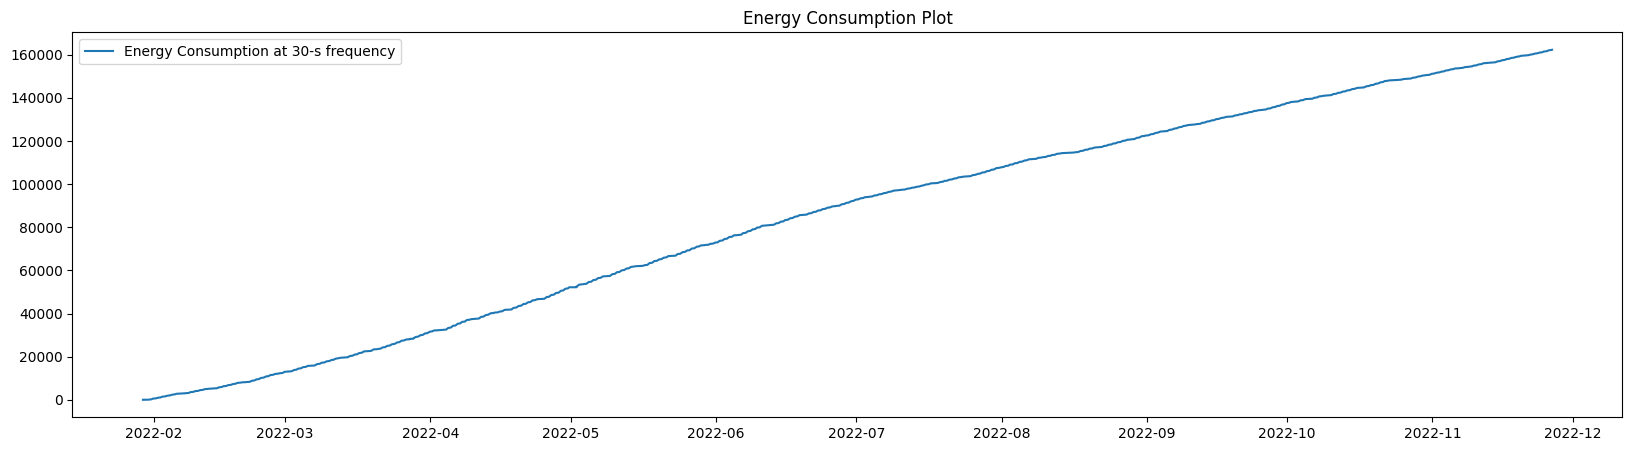

In [6]:
plt.plot(dataset['Time'], dataset['Energy'], label='Energy Consumption at 30-s frequency')
plt.title('Energy Consumption Plot')
plt.legend()

***
Aggregating the dataset to a daily level.
***

In [7]:
agg_dataset = dataset.resample(rule='D', on='Time').sum()

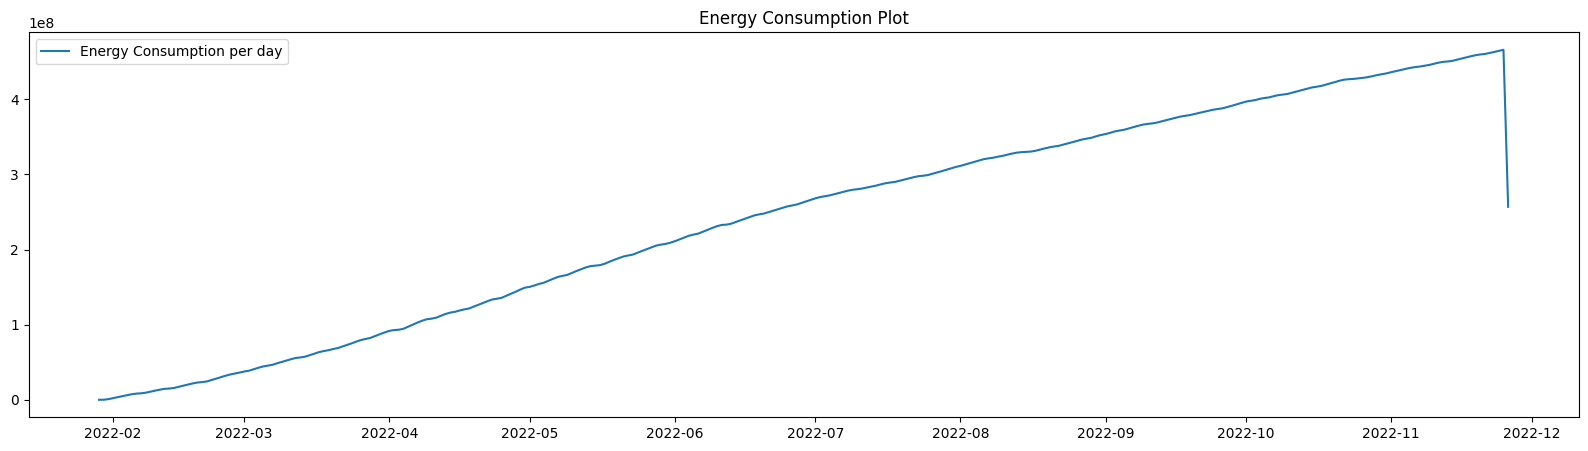

In [8]:
plt.figure(figsize=(20, 5))
plt.plot(agg_dataset, label='Energy Consumption per day')
plt.title('Energy Consumption Plot')
plt.legend()

***
As complete data is not available for the first and last day, the data will be removed for those two days.
***

In [9]:
agg_dataset = agg_dataset[1:-1]

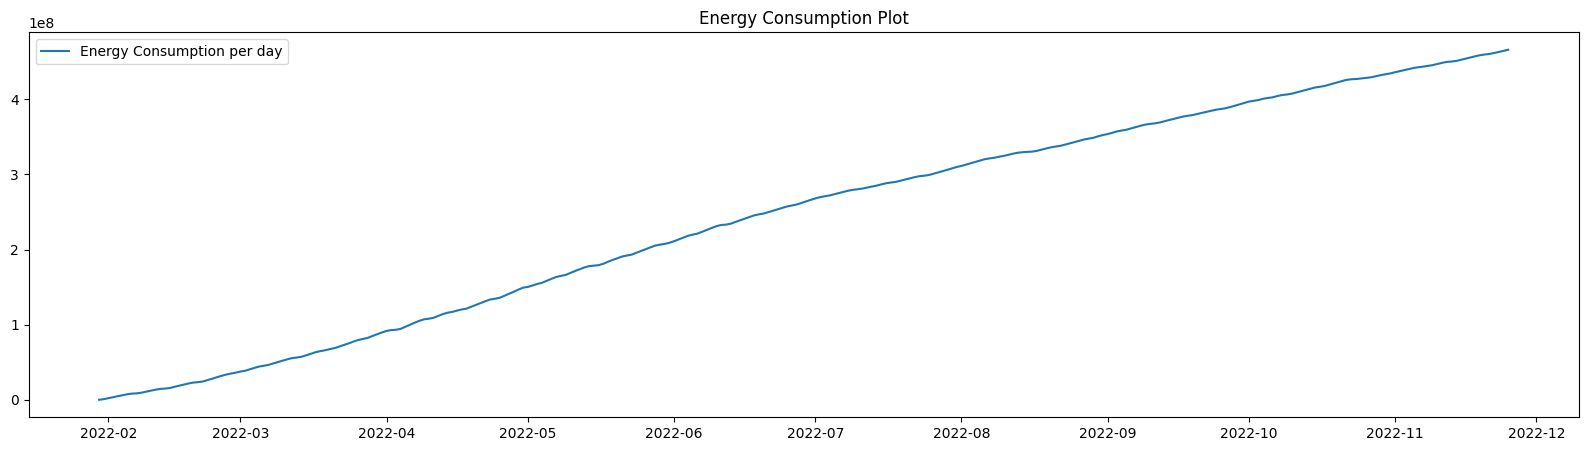

In [10]:
plt.figure(figsize=(20, 5))
plt.plot(agg_dataset, label='Energy Consumption per day')
plt.title('Energy Consumption Plot')
plt.legend()

***
* The plot does not show the presence of outliers.
* The plot has an upward moving trend.
* Decomposing the model to check for seasonality.
***

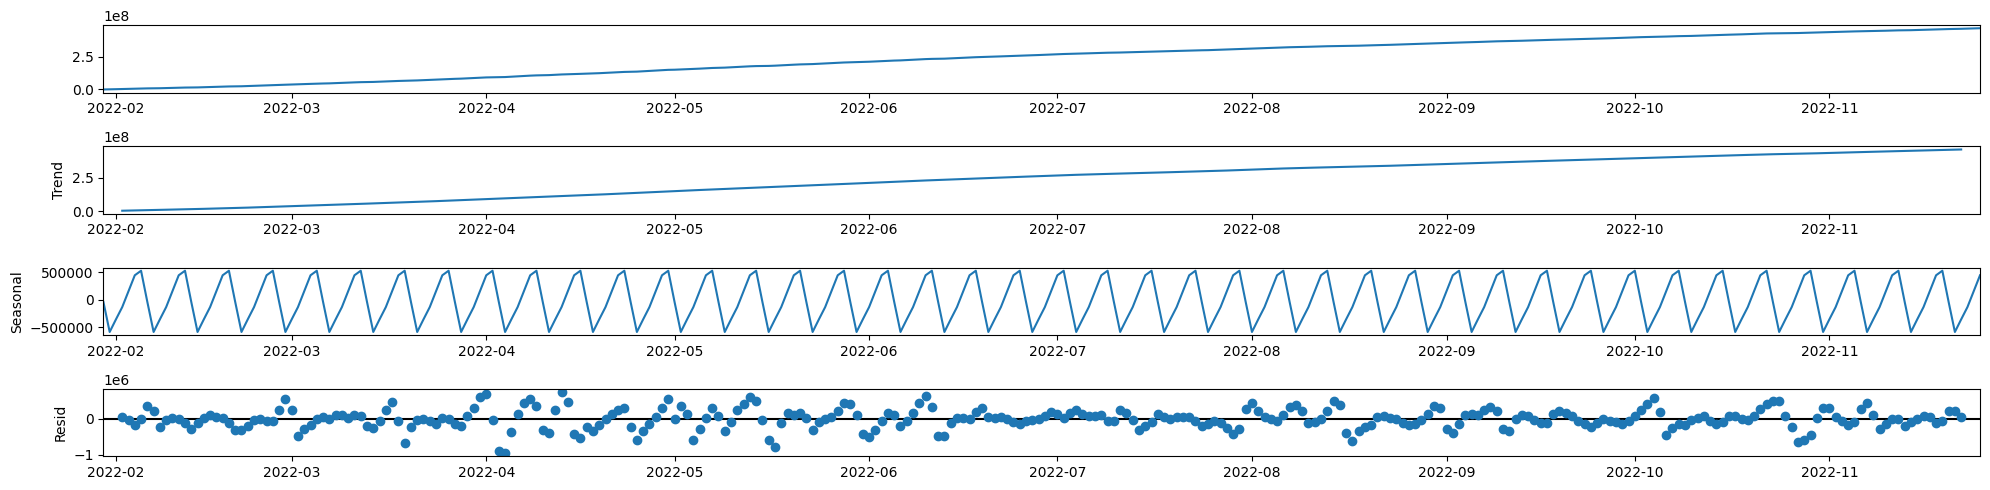

In [11]:
decompose = seasonal_decompose(agg_dataset)
decompose.plot()
plt.show()

***
* A weekly seasonality can be observed.
* Checking for a particular month to confirm the seasonality.
***

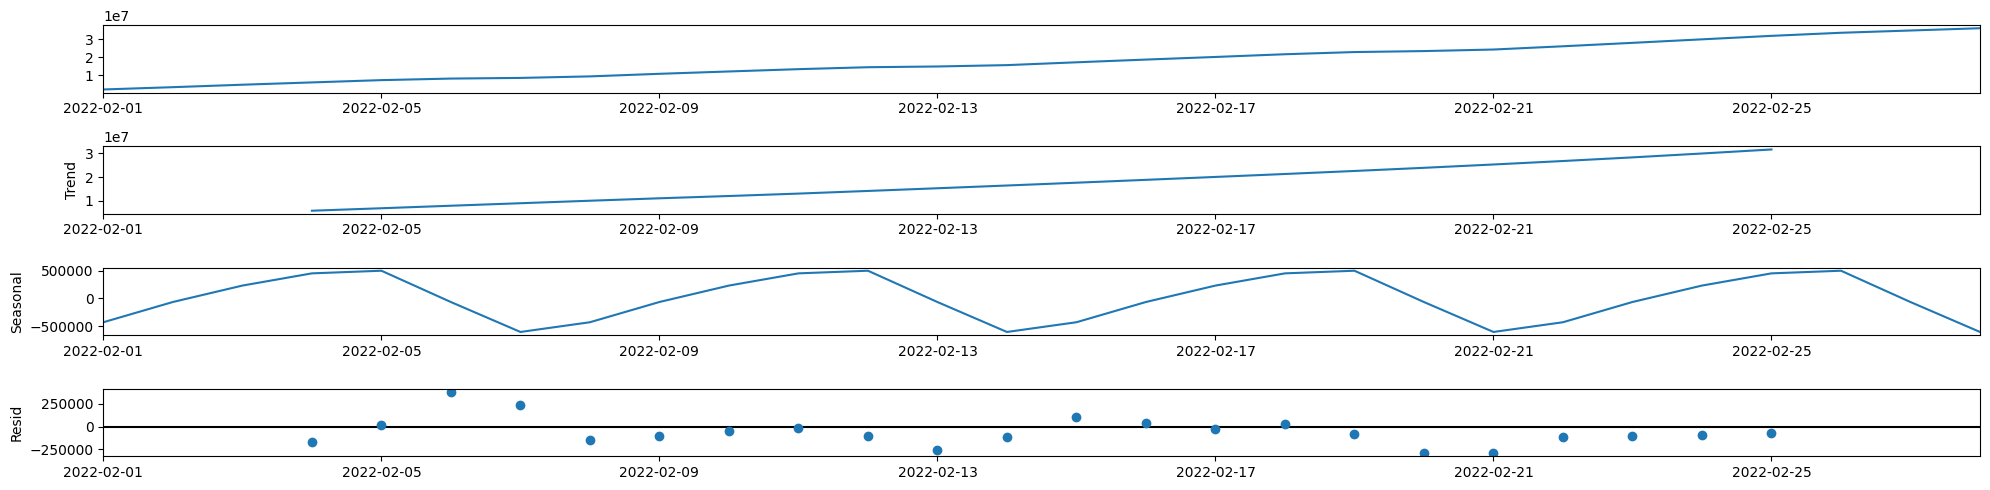

In [12]:
decompose = seasonal_decompose(agg_dataset[agg_dataset.index.month == 2])
decompose.plot()
plt.show()

***
* The weekly seasonality can be confirmed.
* Next step is to check for stationarity.
***

In [13]:
# AD Fuller Test for stationarity
def adf(x):
    res = adfuller(x)
    print('Test-Statistic: ', res[0])
    print('P-Value: ', res[1])
    if res[1] < 0.05:
        print('Stationary')
    else:
        print('Non-Stationary')

In [14]:
adf(agg_dataset)

Test-Statistic:  -2.9178511894488035
P-Value:  0.04331117939127266
Stationary


***
* The dataset is stationary.
* Moving on to model selection.
***

## MODEL SELECTION - SARIMA

* Using PACF plot to determine the AR component.
* Using ACF plot to determine the MA component.
* I component will be 0 as the data is alreay stationary.

c:\Users\utkar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


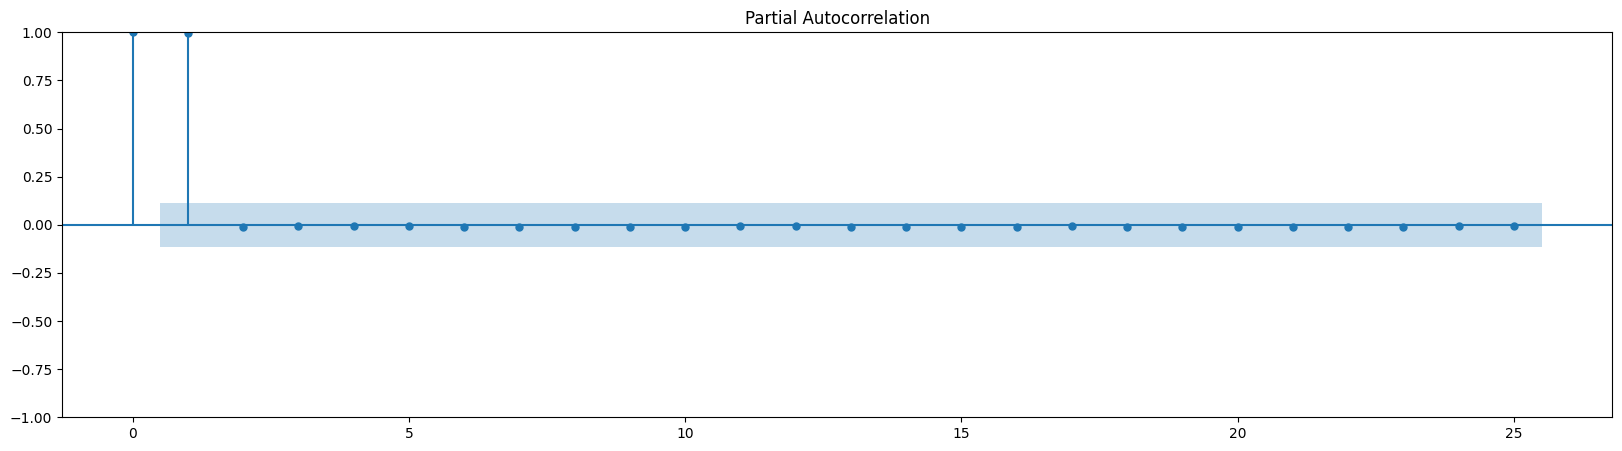

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(agg_dataset['Energy'], ax=ax)
plt.show()

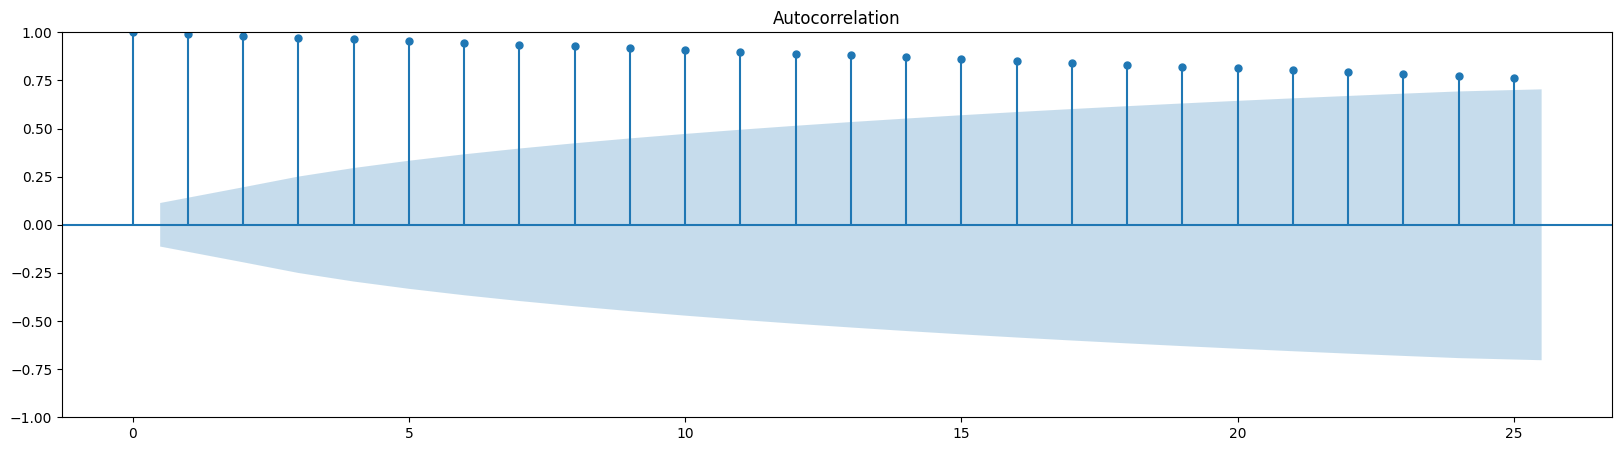

In [16]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(agg_dataset['Energy'], ax=ax)
plt.show()

***
OBSERVATIONS:
* The PACF shows only the previous lag as significant.
* The ACF shows all the lags as significant.
* This suggests that there is a strong correlation between the energy consumption on adjacent days.
* The auto-correlations at lags 2 and above are merely due to the propagation of the auto-correlation at lag 1.
* Therefore, the order is decided of ARIMA is finalized as (p,d,q) = (1,0,0)
***

In [17]:
agg_dataset.head()

,Energy
Time,
2022-01-30,45376.04
2022-01-31,843524.93
2022-02-01,2200839.12
2022-02-02,3473687.82
2022-02-03,4839406.58


***
Removing the first two datapoints and differencing the dataset at 7 days to find out the Seasonal orders.
***

In [18]:
agg_dataset = agg_dataset[2:]

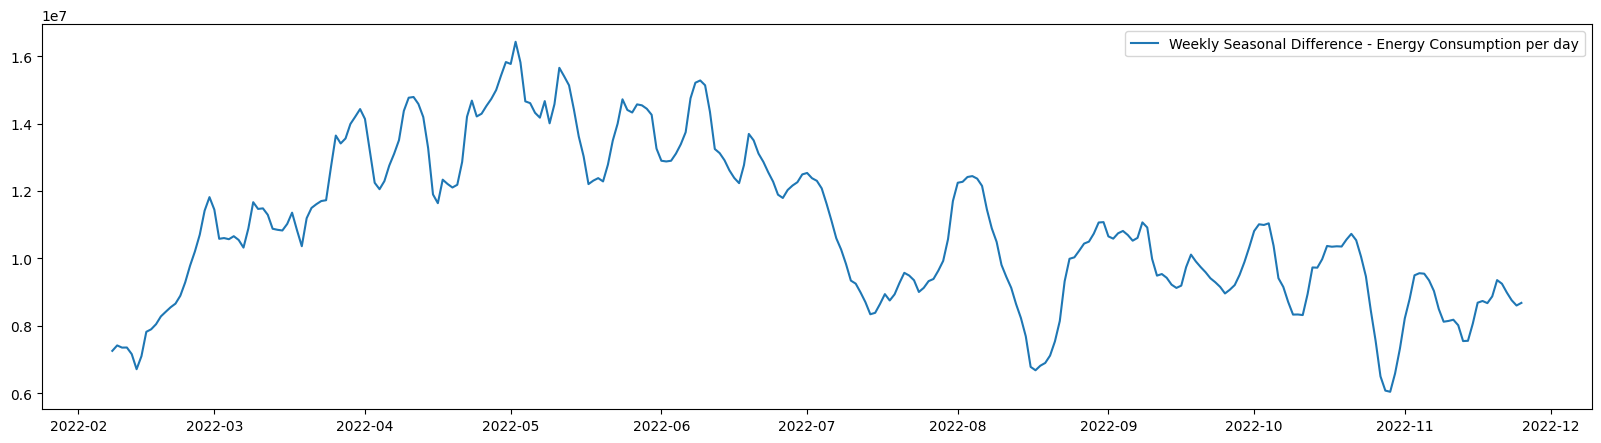

In [19]:
plt.plot(agg_dataset.diff(7)[7:], label='Weekly Seasonal Difference - Energy Consumption per day')
plt.legend()

In [20]:
adf(agg_dataset.diff(7)[7:])

Test-Statistic:  -1.542317613736131
P-Value:  0.5124833217339589
Non-Stationary


In [21]:
adf(agg_dataset.diff(7)[7:].diff(1)[1:])

Test-Statistic:  -5.229501403920313
P-Value:  7.65123381824386e-06
Stationary


***
* The seaonal dataset can be made stationary with a single differencing.
* Therefore the order D = 1
***

c:\Users\utkar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


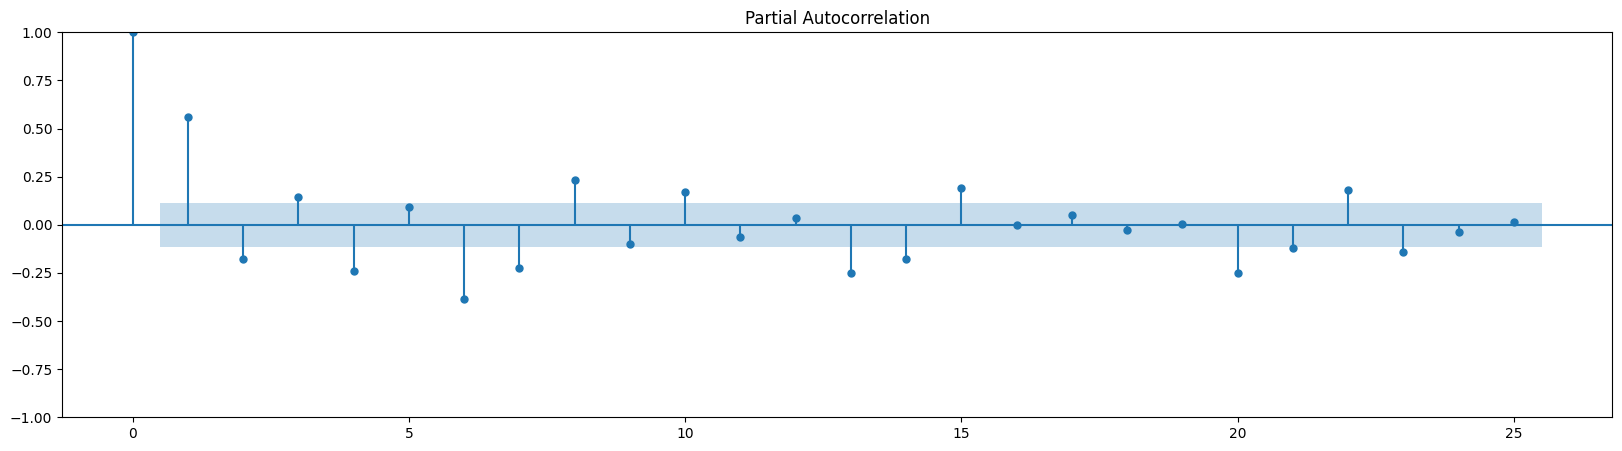

In [22]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_pacf(agg_dataset.diff(7)[7:].diff(1)[1:], ax=ax)
plt.show()

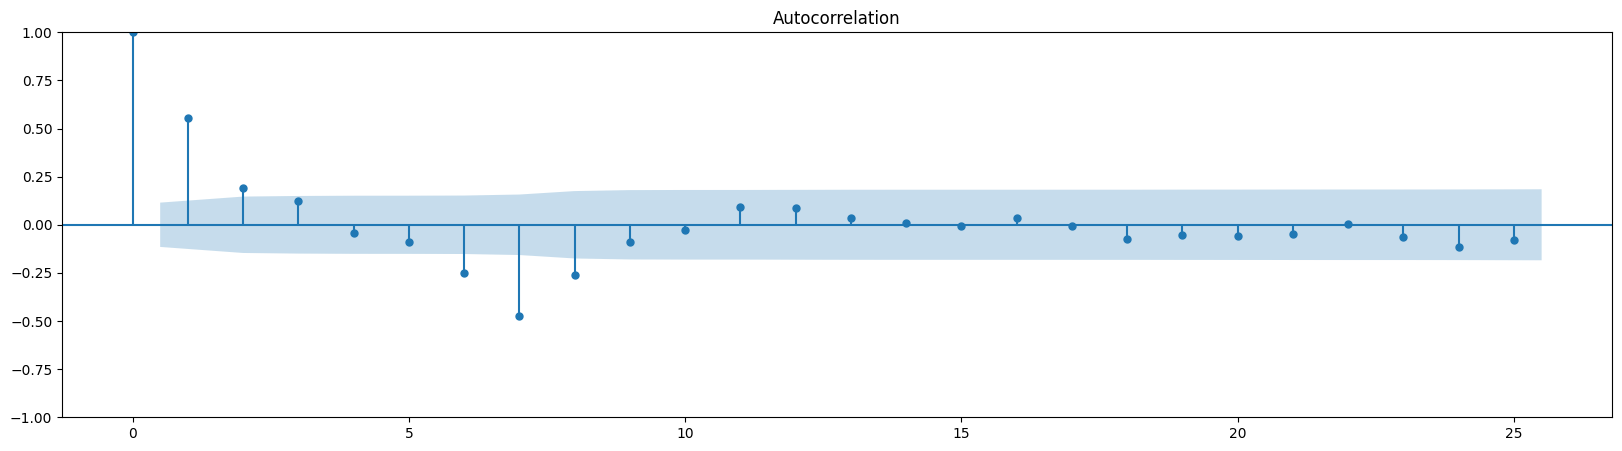

In [23]:
fig, ax = plt.subplots(figsize=(20, 5))
plot_acf(agg_dataset.diff(7)[7:].diff(1)[1:], ax=ax)
plt.show()

***
OBSERVATIONS:
* The PACF shows multiple lags as significant.
* The ACF shows lags 1, 2, 6, 7, 8 as significant.
* Fitting a simpler model and checking the accurancy.
* Therefore, the order is decided of Seasonality is finalized as (P,D,Q) = (1,1,1)
***

## MODEL TRAINING - SARIMA(1,0,0)(1,1,1,7)

* Splitting into training and testing set.
* Taking test sample size as 30 days.

In [24]:
Ntest = 30
train = agg_dataset[:-Ntest]
test = agg_dataset[-Ntest:]

In [25]:
sarima = SARIMAX(train['Energy'], order=(1,0,0), seasonal_order=(1,1,1,7))
sarima_result = sarima.fit()

c:\Users\utkar\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [26]:
train_pred = sarima_result.fittedvalues
prediction_result = sarima_result.get_forecast(Ntest)
conf_int = prediction_result.conf_int()
lower, upper = conf_int['lower Energy'], conf_int['upper Energy']
forecast = prediction_result.predicted_mean

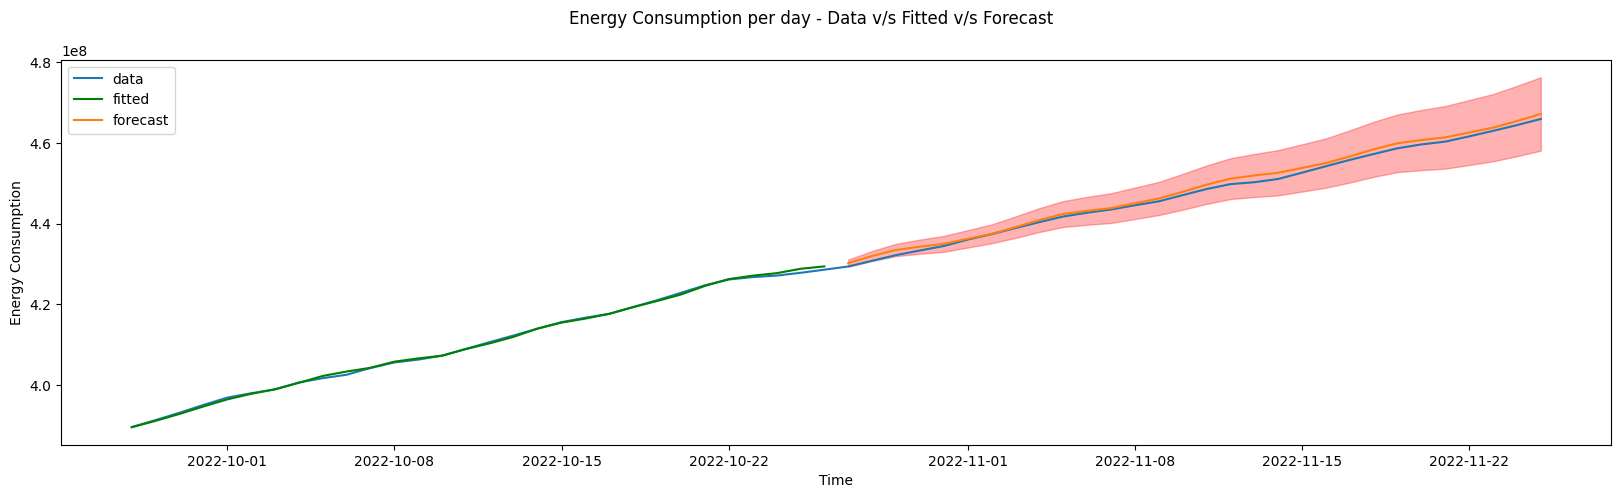

In [34]:
fig, ax = plt.subplots(figsize=(20, 5))
fig.suptitle('Energy Consumption per day - Data v/s Fitted v/s Forecast')

ax.plot(agg_dataset['Energy'][-60:], label='data')

ax.plot(train.index[-30:], train_pred[-30:], color='green', label='fitted')

ax.plot(test.index, forecast, label='forecast')
ax.fill_between(test.index, lower, upper, color='red', alpha=0.3)

ax.set_xlabel('Time')
ax.set_ylabel('Energy Consumption')
ax.legend()

In [28]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return round(np.mean(np.abs((y_true - y_pred) / y_true)) * 100, 1)

In [29]:
print(f'MAPE : {mean_absolute_percentage_error(test, forecast)}')

MAPE : 2.8


## SAVING THE MODEL

Training model on complete dataset.

In [30]:
sarima = SARIMAX(agg_dataset['Energy'], order=(1,0,0), seasonal_order=(1,1,1,7))
sarima_result = sarima.fit()

In [31]:
sarima_result.save('models/sarima_1001117.pickle')